In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from sklearn.metrics import roc_auc_score
from transform import lung_segmentation_transfrom
from model_data import ModelData
import pretrainedmodels
from datetime import datetime
from metrics import dice

In [3]:
PATH = Path('/mnt/data/xray-thesis/data/MontgomerySet')
IMAGE_DN = 'CXR_png'
RIGHT_MASK_DN = 'ManualMask/rightMask'
LEFT_MASK_DN = 'ManualMask/leftMask'
MASK_DN = 'ManualMask/mask'

models_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
print(models_name)
model_path = PATH/'models'/models_name
model_path.mkdir(parents=True, exist_ok=True)

20190125-224938


In [4]:
image_name = 'MCUCXR_0021_0.png'
image = np.array(Image.open(PATH/IMAGE_DN/image_name))

## Train unet

In [5]:
sz = 128
bs = 4 ## 138 image total
nw = 16

In [6]:
class MontgomeryDataset(Dataset):

    def __init__(self, image_names, mask_names, transform, path, size):
        self.image_names = image_names
        self.mask_names = mask_names
        self.path = path
        self.transform = transform
        self.size = size

    def __getitem__(self, i):
        image_file = self.path/self.image_names[i]
        mask_file = self.path/self.mask_names[i]
        
        image = Image.open(image_file).convert('RGB')
        mask = Image.open(mask_file)

        seed = random.randint(0, 2**32)
        if self.transform:
            random.seed(seed)
            image = self.transform[0](image)
            random.seed(seed)
            mask = self.transform[1](mask)

        return image, mask

    def __len__(self):
        return len(self.image_names)
    
    @property
    def sz(self):
        return self.size


In [7]:
image_names = os.listdir(PATH/IMAGE_DN)
x_names = np.array([Path(IMAGE_DN)/name for name in image_names if 'png' in name])
y_names = np.array([Path(MASK_DN)/name for name in image_names if 'png' in name])

In [8]:
val_idxs = list(range(30))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [9]:
val_y[0]

PosixPath('ManualMask/mask/MCUCXR_0369_1.png')

In [10]:
model = pretrainedmodels.__dict__['resnet34']()
tfms = lung_segmentation_transfrom(model, sz)
datasets = ImageData.get_ds(MontgomeryDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH, size=sz)
md = ModelData(PATH, datasets, bs, num_workers=4, classes=None)

In [136]:
# torch.backends.cudnn.benchmark=True
# x,y = next(iter(md.trn_dl))
# x = denorm(x)

In [14]:
# def show_img(im, figsize=None, ax=None, alpha=None):
#     if not ax: fig,ax = plt.subplots(figsize=figsize)
#     ax.imshow(im, alpha=alpha)
#     ax.set_axis_off()
#     return ax

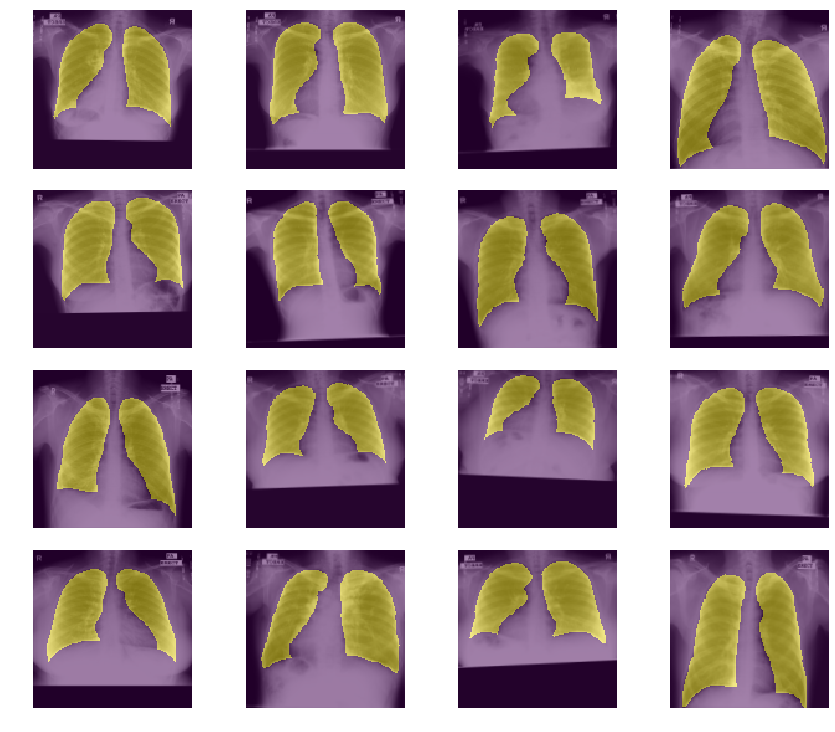

In [148]:
# fig, axes = plt.subplots(4, 4, figsize=(12, 10))
# for i, ax in enumerate(axes.flat):
#     ax = show_img(x[i], ax=ax)
#     show_img(y[i].cpu(), ax=ax, alpha=0.5)
# plt.tight_layout(pad=0.1)

## Unet

In [11]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()


In [12]:
class UnetBlock(nn.Module):
    
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out // 2 # n_out is concat of up_out and x_out
        self.x_conv = nn.Conv2d(x_in, x_out, 1) # 1x1 conv
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
    
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p, x_p], dim=1) # concat along #filter 
        return self.bn(F.relu(cat_p))
    

In [13]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2, 4, 5, 6]]
        self.up1 = UnetBlock(512, 256, 256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
    
    def forward(self, x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
#         return x[:,0]
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [14]:
class UnetModel():
    def __init__(self, model, name='unet'):
        self.model, self.name = model, name
        
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [6]))
        return lgs + [children(self.model)[1:]]

In [15]:
resnet = resnet34(True)
backbone = nn.Sequential(*cut_model(resnet, 8))
unet34 = to_gpu(Unet34(backbone))
unet_model = UnetModel(unet34)

In [16]:
learn = ConvLearner(md, unet_model, models_name=model_path)
learn.opt_fn=optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

In [17]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 

In [196]:
# learn.freeze_to(1)

In [17]:
learn.lr_find()

 96%|█████████▋| 26/27 [00:08<00:00,  4.00it/s, loss=2.05] 


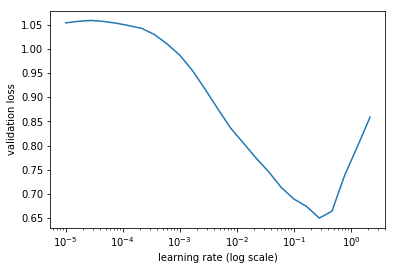

In [18]:
learn.sched.plot(0, 0)

In [19]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [20]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8), best_save_name='best')

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.24742    0.115762   0.923362   0.913729  
    1      0.189086   0.088143   0.933881   0.938709       
    2      0.173588   0.096415   0.929749   0.939442       
    3      0.163691   0.088484   0.934263   0.946709       
    4      0.159191   0.094716   0.930837   0.940849       
    5      0.153177   0.076174   0.938143   0.95152        
    6      0.144602   0.086824   0.932353   0.9408         
    7      0.139953   0.073519   0.938983   0.953811       



[0.07351918170849482,
 array(0.93898, dtype=float32),
 array(0.95381, dtype=float32)]

In [21]:
# x,y = next(iter(md.val_dl))
# py = to_np(learn.model(V(x)))
# show_img(py[0]>0);

NameError: name 'show_img' is not defined

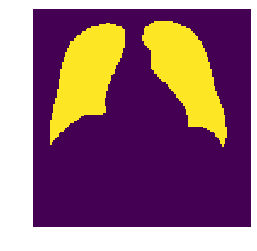

In [206]:
show_img(y[0].cpu());

In [203]:
learn.save('128urn-tmp')

In [204]:
learn.load('128urn-tmp')

In [207]:
learn.unfreeze()
learn.bn_freeze(True)

In [208]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice          
    0      0.061093   0.060042   0.977529   0.954483  
    1      0.059217   0.054062   0.978788   0.958537      
    2      0.055759   0.049763   0.980231   0.961626      
    3      0.053257   0.049393   0.979395   0.961529      
    4      0.051198   0.0448     0.98125    0.965067      
    5      0.049228   0.042789   0.981602   0.966562      
    6      0.04739    0.044584   0.981364   0.965057      
    7      0.0458     0.041588   0.983032   0.967492      
    8      0.044232   0.040781   0.982479   0.967703      
    9      0.042828   0.041271   0.982322   0.96759       
    10     0.041648   0.039658   0.982928   0.96892       
    11     0.040505   0.039143   0.983561   0.969381      
    12     0.039393   0.039012   0.983736   0.969556      
    13     0.038383   0.03814    0.983891   0.970075      
    14     0.037554   0.03786    0.984125   0.970332      
    15     0.036873   0.03762    0.984288   0.970688      
 

[0.03773909683028857, 0.9840149243672689, 0.9704341967900594]

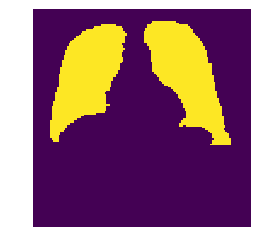

In [211]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))
show_img(py[0]>0);

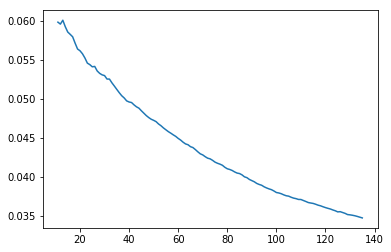

In [212]:
learn.sched.plot_loss()

In [217]:
m.close()

In [218]:
learn.save('128')

## 512x512

In [227]:
sz=512
bs=4

In [228]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [229]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [230]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]
learn.freeze_to(1)

In [231]:
learn.load('128')

In [232]:
learn.lr_find()

 89%|████████▉ | 24/27 [00:36<00:03,  1.14s/it, loss=0.363]

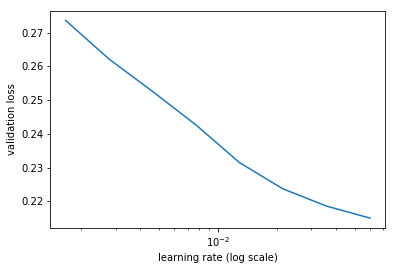

In [233]:
learn.sched.plot()

In [234]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [235]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.086931   0.050676   0.980919   0.963594  
    1      0.061536   0.041369   0.983349   0.969025        
    2      0.050382   0.043764   0.98208    0.968294        
    3      0.043273   0.033883   0.986967   0.973956        
    4      0.038438   0.031029   0.987816   0.975671        


[0.031029047320286433, 0.9878157297770183, 0.9756712039311727]

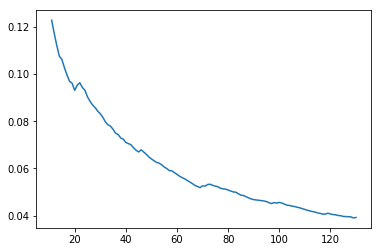

In [241]:
learn.sched.plot_loss()

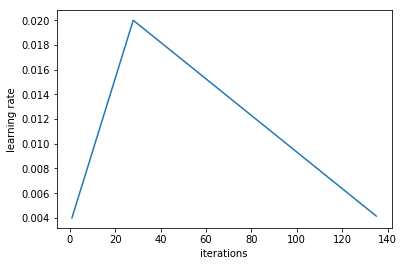

In [242]:
learn.sched.plot_lr()

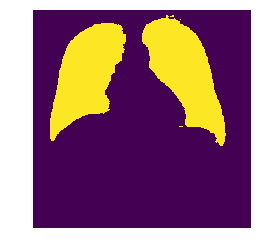

In [236]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))
show_img(py[0]>0);

In [237]:
learn.save('512urn-tmp')

In [238]:
learn.unfreeze()
learn.bn_freeze(True)

In [239]:
learn.load('512urn-tmp')

In [ ]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [243]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.030032   0.02989    0.988166   0.976477  
    1      0.028321   0.028058   0.98888    0.978704        
    2      0.027353   0.029322   0.988625   0.978416        
    3      0.026364   0.030334   0.987998   0.977573        
    4      0.025561   0.027236   0.989178   0.97947         
    5      0.024837   0.028675   0.989394   0.978823        
    6      0.0246     0.029557   0.988052   0.978892        
    7      0.024015   0.027173   0.989277   0.979771        


[0.027172612398862837, 0.9892767588297526, 0.9797705332438151]

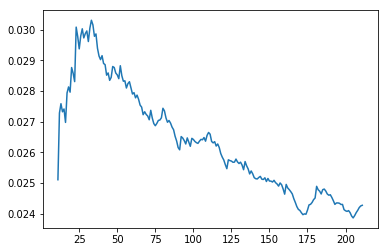

In [245]:
learn.sched.plot_loss()

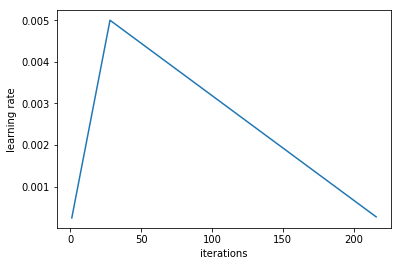

In [246]:
learn.sched.plot_lr()

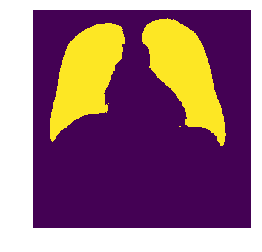

In [247]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))
show_img(py[0]>0);

In [248]:
learn.save('512urn')
m.close()

## 1024x1024

In [16]:
sz=1024
bs=1

In [26]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [35]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [36]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [37]:
learn.load('512urn')

In [38]:
learn.freeze_to(1)

In [39]:
learn.lr_find()

 78%|███████▊  | 84/108 [00:36<00:02,  9.14it/s, loss=0.168] 

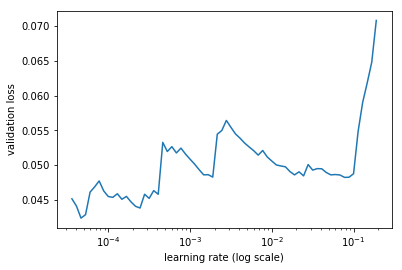

In [40]:
learn.sched.plot()

In [41]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/30,lr])
# lrs = np.array([lr/100,lr/10,lr])

In [42]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.048817   0.045618   0.983614   0.969513  
    1      0.043935   0.043139   0.984323   0.971405          


[0.04313910873606801, 0.9843231836954752, 0.9714046895503998]

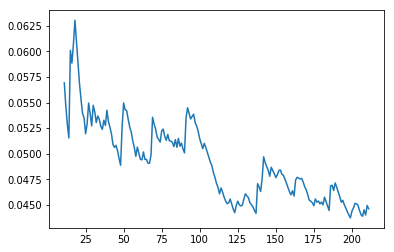

In [43]:
learn.sched.plot_loss()

In [44]:
learn.unfreeze()
learn.bn_freeze(True)

In [45]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.037646   0.043499   0.984191   0.971366  
    1      0.038946   0.043625   0.984177   0.971403          
    2      0.038953   0.043801   0.984136   0.971375          
    3      0.038313   0.043815   0.984143   0.971391          


[0.04381510829553008, 0.9841426531473796, 0.9713914453983307]

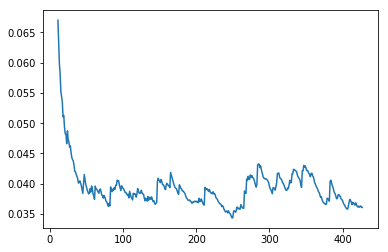

In [46]:
learn.sched.plot_loss()

In [47]:
learn.save('1024urn-tmp')

In [48]:
learn.lr_find()

 31%|███▏      | 34/108 [00:20<00:32,  2.30it/s, loss=0.136] 

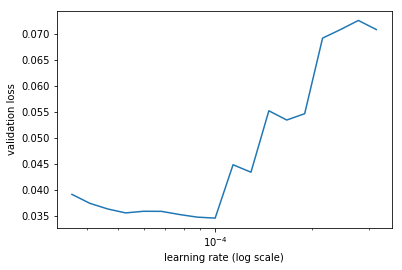

In [49]:
learn.sched.plot()

In [50]:
learn.save('1024')

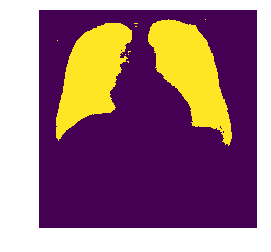

In [53]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))
show_img(py[0]>0);

In [63]:
image = denorm(x.cpu().numpy())
torch.save(learn.model, '1024.pt')

/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Unet34. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UnetBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test on ChestX-ray 14 dataset

In [92]:
from scipy import ndimage
from matplotlib.patches import Rectangle

In [24]:
PATH = Path('/mnt/data/xray-thesis/data/chestX-ray14')
IMAGE_DN = 'images'
CSV_FILE = 'train_list.csv'
df = pd.read_csv(PATH/CSV_FILE)
image_names = df['image']

In [25]:
sample_image_names = np.random.choice(image_names, 16)

In [11]:
model = torch.load('1024.pt')
model = model.eval()

In [12]:
sz = 1024
arch = resnet34
_, tfms = tfms_from_model(arch, sz)

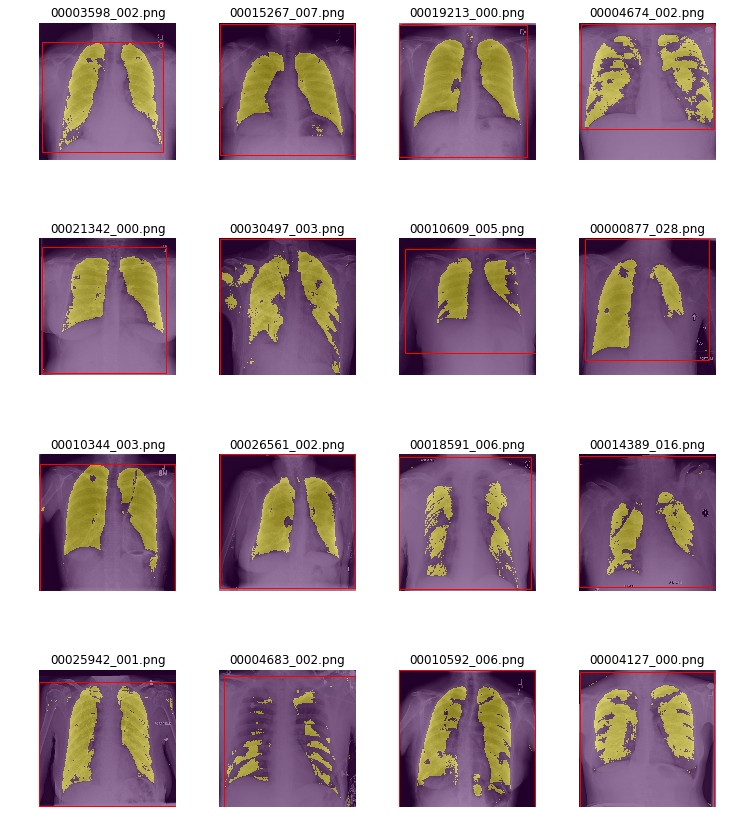

In [94]:
fig, axes = plt.subplots(4, 4, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    image = open_image(PATH/IMAGE_DN/sample_image_names[i])
    ax.set_title(sample_image_names[i])
    
    ax = show_img(image, ax=ax)
    image = Variable(torch.Tensor(tfms(image))[None]).cuda()
    py = to_np(model(image))
    show_img(py[0] > 3, ax=ax, alpha=0.5)
    
    slice_x, slice_y = ndimage.find_objects(py[0] > 0, True)[0]
    xy = (slice_y.start, slice_x.start)
    height = slice_x.stop - slice_x.start
    width= slice_y.stop - slice_y.start
    rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.tight_layout(pad=0.1)

In [64]:
from scipy import ndimage
from matplotlib.patches import Rectangle

matplotlib.patches.Rectangle

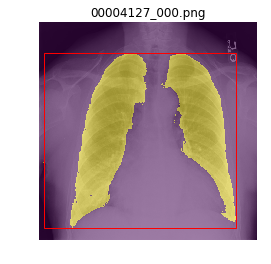

In [91]:
image_name = '00003598_002.png'
image = open_image(PATH/IMAGE_DN/image_name)
ax = show_img(image)
ax.set_title(sample_image_names[i])
data = Variable(torch.Tensor(tfms(image))[None]).cuda()
py = to_np(model(data))
show_img(py[0] > 0, ax=ax, alpha=0.5)
slice_x, slice_y = ndimage.find_objects(py[0] > 0, True)[0]
xy = (slice_y.start, slice_x.start)
height = slice_x.stop - slice_x.start
width= slice_y.stop - slice_y.start
rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)


In [90]:
xy, width, height

((145, 21), 824, 906)

In [86]:
# slice_x, slice_y = ndimage.find_objects(py[0] > 0, True)[0]

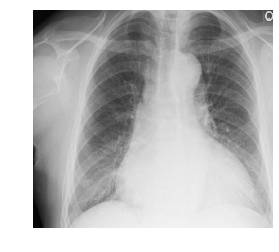

In [89]:
roi_image = image[slice_x.start:slice_x.stop, slice_y.start: slice_y.stop]
show_img(roi_image)


In [58]:
slice_y.stop

927